# Learning-Based Model Predictive Control for Autonomous Racing

In this Notebook I am doing a quick implementation of the Learning-Based Model Predictive Control framework, proposed by Kabzan et.al. (2019). The paper that introduces this algorithm can be found through the following link.

https://www.research-collection.ethz.ch/handle/20.500.11850/351561

I am doing this implementation purely to understand the concept as detailed as possible in preperation for an interview for a master's thesis. 

All credit for the development of this framework goes to Kabzan et.al..

All the constants, weights and gains are set to random or estimated values.

In a serious implimentation the controller would probably be implimented as a subclass of some sort, updating the internal vehicle state variables. But since this just for my familiarization with the given framework, I used simple functions to achieve the desired computation. These could be in theory be adaped and used in a more serious aproach.

In [1]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from numpy.linalg import eig
from numpy.linalg import norm
from scipy.integrate import solve_ivp
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import random

%matplotlib inline

In the following cell, I define the some constants and initial values as well as the initial statevector and driver input vector. Additionaly, I am creating the dictionary for the collection of trainingdata for the Gaussian Process Regression and the subspace definition matrix B_d


In [2]:
# Nominal Vehicle Model
m = 1000 # vehicle mass [kg]
I_z = 2000 # yaw moment of interia [kg m²]
l_R = 1.5 # distance from the center of gravity of the car to the rear axle [m]
l_F = 1.5 # distance from the center of gravity of the car to the front axle [m]
P_TV = 0.5 # proportional controller gain for the torque vectoring controler [positive real number]

D_F = 1 # Tire constants for the computation of the drive-train Y-forces
D_R = 1
C_F = 1.9
C_R = 1.9
B_F = 10
B_R = 10

C_m1 = 50 # Drivetrain constant for the Computation of F_x
C_r0 = 1 # Rolling resistance
C_r2 = 1 # Drag coefficient


### Initializing the first statevector for the model with the initial values----------------------------------------------
X_0 = 0 # Initial X position (global)
Y_0 = 0 # Initial Y position (global)
phi_0 = 0 # Initial heading angle (global)
v_x_0 = 0.000000001 # Initial x velocity (vehicle) not 0 to avoid problems with the integral
v_y_0 = 0.000000001 # Initial y velocity (vehicle) not 0 to avoid problems with the integral
r_0 = 0 # Initial yaw rate
delta_0 = 0.01 # Initial steering angle 
T_0 = 1 # Initial desired accaleration

x = np.array([[X_0, Y_0, phi_0, v_x_0, v_y_0, r_0, delta_0, T_0]]) # Initial state vector x


### Initializing the first inputvector for the model with initial values----------------------------------------
d_delta_0 = 0 # Initial change in steering angle
d_T_0 = 0 # Initial change in desired acceleration

u = np.array([[d_delta_0, d_T_0]]) # Initial driver inputs to the system


### Initializing the empty dictionary for the Gausian Process Regression
D = {}


### Initializing the Subspace definition matrix B_d
B_d = np.zeros((8,3))
B_d[3:6,:] = np.eye(3)


## Nominal vehicle model
In the next cell, all the relevant functions for the nominal state computation of the vehicle, and the collection of regression features and training data, are defined.

In [3]:
### Definition of the vehicle dynamics function---------------------------------------------------------------------------
def vehicle_dynamics(t, x):
    '''This function takes as an input a statevector x and outputs the analytical derivitive of the statevector x_dot.
    This function is only ment to be called through the nominal_vehicle_state() function.'''
    
    # Decomposing the statevector into its different values
    X = x[0]
    Y = x[1]
    phi = x[2]
    v_x = x[3]
    v_y = x[4]
    r = x[5]
    delta = x[6]
    T = x[7]
    d_delta = u_temp[0]
    d_T = u_temp[1]
    
    '''Computing the additional yaw torque from the torque-controller, the front and read slip angles 
    and the longitudinal drive-train forces. l_R, l_F and P_TV are the distances to the front and 
    read axles and the the gain for the torque-controller respectively.'''
    
    r_target = delta*(v_x/(l_R+l_F))
    tau_TV = (r_target - r)*P_TV # Additional torque generated by the torque vectoring controller
    
    alpha_R = np.arctan((v_y - l_R*r)/v_x) # Front slip angle
    alpha_F = np.arctan((v_y + l_F*r)/v_x) - delta # Rear slip angle
    F_Ry = D_R*np.sin(C_R*np.arctan(B_R*alpha_R)) # Rear lateral force
    F_Fy = D_F*np.sin(C_F*np.arctan(B_F*alpha_F)) # Front lateral force
    F_x = C_m1*T - C_r0 - C_r2*(v_x**2) # Applied longitudinal force
    
    # Computing the values of x_dot
    X_dot = v_x*np.cos(phi) - v_y*np.sin(phi)
    Y_dot = v_x*np.sin(phi) + v_y*np.cos(phi)
    phi_dot = r
    v_x_dot = (F_x - F_Fy*np.sin(delta) + m*v_y*r)/m
    v_y_dot = (F_Ry + F_Fy*np.cos(delta) - m*v_x*r)/m
    r_dot =  (F_Fy*l_F*np.cos(delta) - F_Ry*l_R + tau_TV)/I_z
    delta_dot = d_delta 
    T_dot = d_T
    
    x_dot = np.array([X_dot, Y_dot, phi_dot, v_x_dot, v_y_dot, r_dot, delta_dot, T_dot])
    
    return x_dot


### Definition of the integration step for the nominal vehicle state------------------------------------------------------
def nominal_vehicle_state(x, u):
    '''Use the Runge-Kutta 4/5th order integration to solve for the new nominal state of the vehicle
    This is probably not entirely right. If I set the initial velocity to 0, the integral gets stuck.
    x = x[k]
    u = u[k]'''
    
    global u_temp # I assign this variable globaly so I can call it when solving the ODE
    u_temp = u
    state = solve_ivp(vehicle_dynamics, t_span = (0, 0.05), y0 = x).y.T[-1]
    del u_temp # Deleting the global variable just to be sure...
    return state
    
    
### Definition of the function to get the needed regression features------------------------------------------------------
def get_regression_features(x, u):
    '''This function takes as argument the a statevector x and a driverinput u and outputs a featurevector
    z which is used in the Gausian Process Regression.
    x = x[k]
    u = u[k]'''
    
    z = np.array([x[3], x[4], x[5], x[6] + u[0]*0.5, x[7] + u[1]*0.5])
    return z


### Definition of the training data generation function-------------------------------------------------------------------
def get_training_data(a, x, u):
    '''The function outputs the training data y for a given point k+1 by taking the measured vehicle state a, and 
    the computed state through the nominal vehicle model. This results in y containg the error of the prediction of 
    nominal vehicle model. 
    The traning data is put into the dictionary D together with the correspoinding regression features.
    a = measured state of the vehicle at time k+1
    x = x[k]
    u = u[k]'''
    
    y = pinv(B_d)@(a - nominal_vehicle_state(x, u))
    return y

Below I verify my implementation of the nominal state computation by running tests with some constant steering (0.01rad) and accaleration (1) inputs.

IMPORTANT: The acctual values e.g. acceleration are not realistic because I estimated all the constants like drivetrain and the constants for the tire model. This means that all the values get obscured from realistic vehicle behaviour. for example an acceleration of 1 which equals to the maximum acceleration possible would not result in the the kind of velocity increase you would expect.

In [4]:
u_new = np.array([d_delta_0, d_T_0]) # Ensuring there is no driver input, just for testing means

for k in range(2000):
    
    x_new = nominal_vehicle_state(x[k], u[k]) # computing x[k+1]
    
    z_new = get_regression_features(x[k], u[k]) # computing corresponding regression features
        
    #y_new = get_training_data(x_new, x[k], u[k]) # computing corresponding trainig data 
    # I am generating random training data to have something to put into D
    y_new = (random.randint(0,50),random.randint(30,80),random.randint(120,170)) 
    
    ### Needs MPC for computation of u_new
    
    x = np.append(x, np.array([x_new]), axis=0) # appending the new statevector
    u = np.append(u, np.array([u_new]), axis=0) # appending the new driverinput
    
    D[tuple(y_new)] = tuple(z_new) # adding datapoint to trainingdictionary D # Filled D to test GPR


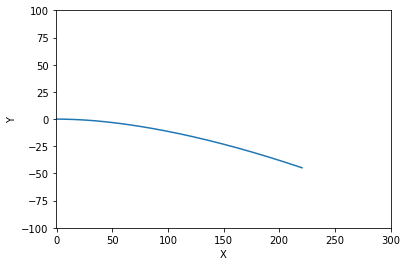

In [5]:
xplot = x.T[0]
yplot = x.T[1]
plt.xlim(-1,300)
plt.ylim(-100,100)
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(xplot,yplot)
plt.show()

The plot shows the X and Y coordinates of the vehicle after the first 2000 iterations. 
For a constant acceleration and steering angle the plot looks realistic.
The fact that with more iterations, the constant steering angle delta has less and less effect on the trajectory is possibly due to the decreasing sideslip angle (the value of arctan decreases as the denominator increases), and the consequently decreasing lateral forces on the vehicle. 

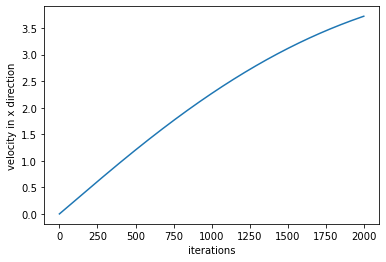

In [6]:
xplot = range(2001)
yplot = x.T[3]
plt.xlabel("iterations")
plt.ylabel("velocity in x direction")
plt.plot(xplot,yplot)
plt.show()

This plot also makes sense, since the velocity should increase linear with a constant accaleration. The flattening during the end is most likely due to the dragcoefficient preventing the vehicle from increasing its velocity linearly.

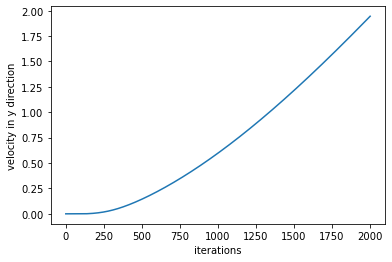

In [7]:
xplot = range(2001)
yplot = x.T[4]
plt.xlabel("iterations")
plt.ylabel("velocity in y direction")
plt.plot(xplot,yplot)
plt.show()

since the y_velocity is in bodyframe, the drag has no impact on it, which means it is steadily increasing due to the constant steering angle. 

The cell below, shows that with higher drag-coefficient, the x_velocity plateaus after about 1000 iterations.

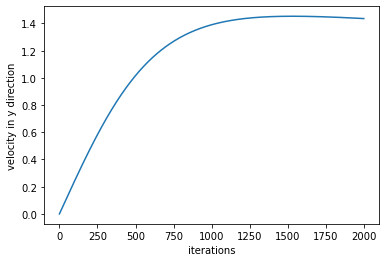

In [8]:
### Initializing the first statevector for the model with the initial values----------------------------------------------

C_r2 = 20

X_0 = 0 # Initial X position (global)
Y_0 = 0 # Initial Y position (global)
phi_0 = 0 # Initial heading angle (global)
v_x_0 = 0.000000000000001 # Initial x velocity (vehicle) not 0 to avoid problems with the integral
v_y_0 = 0.000000000000001 # Initial y velocity (vehicle) not 0 to avoid problems with the integral
r_0 = 0 # Initial yaw rate
delta_0 = 0.01 # Initial steering angle 
T_0 = 1 # Initial desired accaleration

x = np.array([[X_0, Y_0, phi_0, v_x_0, v_y_0, r_0, delta_0, T_0]]) # Initial state vector x

### Here I am initializing the first inputvector for the model with initial values----------------------------------------

d_delta_0 = 0 # Initial change in steering angle
d_T_0 = 0 # Initial change in desired acceleration

u = np.array([[d_delta_0, d_T_0]]) # Initial driver inputs to the system
u_new = np.array([d_delta_0, d_T_0]) # Ensuring there is no driver input, just for testing means

for k in range(2000):
    
    x_new = nominal_vehicle_state(x[k], u[k]) # computing x[k+1]
    y_new = (random.randint(0,50),random.randint(30,80),random.randint(120,170))
    
    ### Needs MPC for computation of u_new
    
    x = np.append(x, np.array([x_new]), axis=0) # appending the new statevector
    u = np.append(u, np.array([u_new]), axis=0) # appending the new driverinput

xplot = range(2001)
yplot = x.T[3]
plt.xlabel("iterations")
plt.ylabel("velocity in y direction")
plt.plot(xplot,yplot)
plt.show()

## Gaussian Process Regression

This is a very basic implementation of the GRP using the corresponding sklearn module. 

In [9]:
'''After every training lap, the parameters for the Gaussian Process regression are set and the regressor is fit,
using the data from D'''

w_k = [0, np.eye(3)*0.1] # zero meaned gaussian noise with (made up) variance matrix
sigma_f_a = 0.1 # In the paper this is said to be the signal variance. Not sure what is ment by that.


L_a = np.ones(5) # length matrix of size n_z x n_Z
kernel = sigma_f_a**2*RBF(L_a) # Squared exponential kernal for the GPR

# Fitting the GPR to the values in D
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(list(D.values())[0:250], list(D.keys())[0:250])
    

Together, with the nominal vehicle model one could now iteratively compute the vehicle state, using the following expression.
Additionaly this would be the time to compute the training data y[k] which may be used in kombination with z[k] in future learning iterations of the GPR.

In [10]:
z_new = get_regression_features(x[k], u[k]) # computing corresponding regression features

x_new = nominal_vehicle_state(x[k], u[k]) + B_d@(gpr.predict(np.array([z_new])).T + w_k[0]) # computing x[k+1]

y_new = get_training_data(x_new, x[k], u[k])

## MPC formulation

since I am not going to impliment a Solver, I will just write down the equasions for the objective function and the constrains for the MPC optimization problem. 
These could propably be inserted in a python solver. In that case the functions would need to be transfered and the variables adjusted. Obviously the forumlation of the objective function and the constraints would also have to be changed.

In [11]:
### Defining the constants needed in the optimization problem
q_c = 1
q_l = 1
q_beta = 1
kappa = 1

# min/max values for stearing angle and driver command and their respective rate of change
delta_min = -np.pi/4
delta_max = np.pi/4
T_min = -0.3
T_max = 0.3
d_delta_min = 0.1
d_delta_max = 0.1
d_T_min = 0.1
d_T_max = 0.1

p_long = 1 # Defining the tire-specific frictional ellipse
p_ellipse = 1 # Defining the tire-specific frictional ellipse


### Representation of the Track
'''The track that is supposed to be followed is parameterized by the variable theta, element of [0,theta_max].
The track is specified by four parameters. The X and Y coordinates of the centerline (X_c[theta] and Y_c[theta]), 
the orientation of the track (phi_c[theta]), and the Radius R_c[theta] which corresponds to the width of the track
at point theta.'''

'''This is a simple mockup of the relevant parameters to reference something in the functions
of how the track could be parameterized. In a real system these parameters would most likely be computed by the
sensors of the car. The shape of this example-track is (theta_max, 4).'''
track = np.array([[0, 0, 0, 5], [1, 0, 0, 5], [2, 0, 0, 5]]) 


Next, I will define all the functions neccecary for the objective function and the constraints of the controller.

In [12]:
### Defining the contouring error function
def e_c(mu_x, theta):
    '''This function computes the contouring error and is used in the contouring cost function.
    It takes as an input a predicted state mu_x and the correspoinding position of the track theta.'''
    
    return -np.cos(track[theta][2])*(mu_x[0] - track[theta][0]) - np.sin(track[theta][2])*(mu_x[1] - track[theta][1])

### Defining the lag error function
def e_l(mu_x, theta):
    
    return np.sin(track[theta][2])*(mu_x[0] - track[theta][0]) - np.cos(track[theta][2])*(mu_x[1] - track[theta][1])


### Defining the contouring cost function
def cont_cost(mu_x, theta, v):
    '''This function computes the contouring cost for the objective function of the MPC.
    It takes as input the predicted state of the vehicle mu_x, the track progress variable theta
    and the decisionvariable v, at prediction time k.
    It is worth mentioning that the model aims to maximize v, which, taken into consideration the constraint of the
    optimization model, maximizes the vehicles progress along the track.'''
    
    return q_c*e_c(mu_x, theta)**2 + q_l*e_l(mu_x, theta)**2 - kappa*v


### Defining the first regularization term
def reg1(mu_x, u):
    '''This function computes the first regularization term for the objective function of the MPC.
    It takes as input the predicted state of the vehicle mu_x, and the decisionvariable u, at prediction time k.
    R_x and R_u are used in the paper to compute the vectorized 2-norm but I did not find there exsact definition.'''
    vec1 = np.array([[mu_x[6]],[mu_x[7]]])
    vec2 = np.array([[u[0]],[u[1]]])
    
    return vec1.T@R_x@vec1 + vec2.T@R_u@vec2


### Defining the second regularization term
def reg2(mu_x):
    '''This function computes the first regularization term for the objective function of the MPC.
    It takes as input the predicted state of the vehicle mu_x. This regularizationterm is a 
    penalty for driving agressiveness'''
    beta_dyn = np.arctan(mu_x[4]/mu_x[3])
    beta_kin = np.arctan(np.tan(mu_x[6])*l_R/(l_R+l_F))
    return q_beta*(beta_kin - beta_dyn)**2


### Defining a function for the propagation of the predicted vehicle state and variance matrix
def propagate_vehicle_state(mu_x, u):
    '''This function propagates the estimated state and the variance matrix through the lookahead distance.
    It takes as unput the current predicted state mu_x[k], the corresponding variance matrix var_mat_x[k], and
    the decisionvariable u[k].gpr_tile is a sparse Gaussian Process regression model which is a modification
    to the standart GPR. The function returns a list, containing the k+1th mu_x vector and the k+1th variance matrix'''
    
    mu_x_new = nominal_vehicle_state(mu_x, u) + B_d@gpr_tilde.predict(get_regression_features(mu_x, u))
    
    return mu_x_new


### Defining a function that computs R_GP
def compute_R_GP(var_mat_x):
    '''This function computes the R_GP, which is part of the variance constraint wich is used to constraint the
    vehicle to a smaller trackradius then the nominal one, by taking into account the corresponding variance on the
    computed X and Y position values.
    The paper states that the quantiles are precomputed based on the previous solution trajectory'''
    
    w, v = eig(var_mat_x[0:2, 0:2])
    return np.squrt(chi2.pdf(0.05, 2)*min(w)) # I set p to 5% now, because it was not further specified

Here I tried to get as close to the formulation of the given optimization problem. Obviously this wouldnt work, but it helped me to understand the purpose and way of working of the different constraints.

In [ ]:
### Objective function of the MPC -- this would look much different in an acctual solver
'''The decition variables that are optimized for are u[k] = [u[k][0], u[k][1]] and v[k]'''
N = 40 # Prediction Horizon

objective_function_value = 0
for k in range(N):
    objective_function_value += (cont_cost(mu_x[k], theta[k], v[k]) + reg1(mu_x[k], u[k]) + reg2(mu_x[k]))
    
MINIMIZE: objective_funtion_value

### Constraint 1
'''This constraint defines the momentary statevector of the vehicle (x[t]) as the starting point for the 
lookahead of the controller. x[t] is most likely optained by sensor supported stateestimation algorithms.'''
mu_x[0] = x[t]

### Constraint 2
'''This constraint defines how mu_x is iteratively updated to estimate the vehicle state through the lookahead distance.'''
mu_x[k+1] = propagate_vehicle_state(mu_x[k], u[k])

### Constraint 3 
'''This constraint specifies the vehicles progression along the track. The model tries to make as much progression as 
possible, meaning completing the track as fast as possible. This is because the decisionvariable v[k] is maximized in
objective function of the MPC.'''
theta[k+1] = theta[k] + v[k]

### Constraint 4
''' This constraint ensures that the vehicle stays within the track by ensuring that the predicted position is not moving 
further from the centerline then the with of the track at that point, minus the variance-value R_GP.
It is important to note that for this constraint precomputed values from the last iteration of the controller are used.
This means the theta value and the variance matrix for this constrain, stay fixed through the whole optimization process
to esure computational feasibility.'''
norm(np.array([[mu_x[k][0] - track[theta_fixed[0]]],[mu_x[k][1] - track[theta_fixed[1]]]])) <= \
norm(track[theta_fixed][4]-compute_R_GP(var_mat_x))

### Constaint 5(a,b)
''' This constraint limits the tire forces to the frictional elipse. If this controller would be implimented as a class,
the tire-forces could be computed and updated as a state of the class, meaning they could be referenced in the MPC.'''
(p_long*F_x)**2 + F_Fy**2 <= (p_ellipse*D_F)**2
(p_long*F_x)**2 + F_Ry**2 <= (p_ellipse*D_R)**2

### Constraint 6
''' This constraint limits the steering angle delta and driver command T as well as their rate of change to 
maximum/minimum values'''
delta_min <= mu_x[k][6] <= delta_max
d_delta_min <= u[k][0] <= d_delta_max
T_min <= mu_x[k][7] <= T_max
d_T_min <= u[k][1] <= d_T_max